In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def concat(fields, fd):
    return fd[fields].T.values

def pool(name, df):
     return df[df['pool'] == name].drop(columns=["pool"])

def rw_ratio(ratio, df):
     return df[df['rw_ratio'] == ratio].drop(columns=["rw_ratio"])

def merge_ratios(fd):
    m = fd["threads"].drop_duplicates()
    for r, n in [(100, 'ro'), (66, 'rrw'), (50, 'rw'), (33, 'rww'), (0, 'wo')]:
        t = rw_ratio(r, fd).rename(columns={'ltnc':n,'ltnc_d':n+'_d'})
        m = pd.merge(m, t)
    return m

def plot_ratios(fd, axs):
    fd = merge_ratios(fd)
    fd.plot(
        ax=axs,
        x='threads',
        ylabel='latency (ns)',
        y=['ro','rrw','rw','rww','wo'],
        yerr=concat(['ro_d','rrw_d','rw_d','rww_d','wo_d'], fd))
    

In [2]:
data = pd.read_csv('pmbench.csv', delimiter = ",")
data

,pool,threads,size,working_set,rw_ratio,ltnc,ltnc_d,offset,pattern,mode
0,fsdax,1,256,128,0,181,0.00,uniform,random,App
1,ram_l,1,256,128,0,32,0.00,uniform,random,App
2,pm_l,1,256,128,0,38,0.00,uniform,random,App
3,ram_r,1,256,128,0,179,0.00,uniform,random,App
4,pm_r,1,256,128,0,274,0.00,uniform,random,App
...,...,...,...,...,...,...,...,...,...,...
565,ram_l,32,98304,49152,50,2044,3.86,uniform,random,Mem100
566,ram_l,32,98304,49152,100,66,7.16,uniform,random,Mem100
567,ram_l,34,98304,49152,0,3185,186.43,uniform,random,Mem100
568,ram_l,34,98304,49152,50,2171,124.21,uniform,random,Mem100


In [3]:
apps = data[
    (data["offset"] == "uniform") &
    (data['pattern'] == "random") &
    (data['mode'] == "App") &
    True].drop(columns=["offset","pattern","mode","size","working_set"])

apps_fsdax = pool('fsdax', apps)
apps_ram_l = pool('ram_l', apps)
apps_ram_r = pool('ram_r', apps)
apps_pm_r  = pool('pm_r',  apps)
apps_pm_l  = pool('pm_l',  apps)

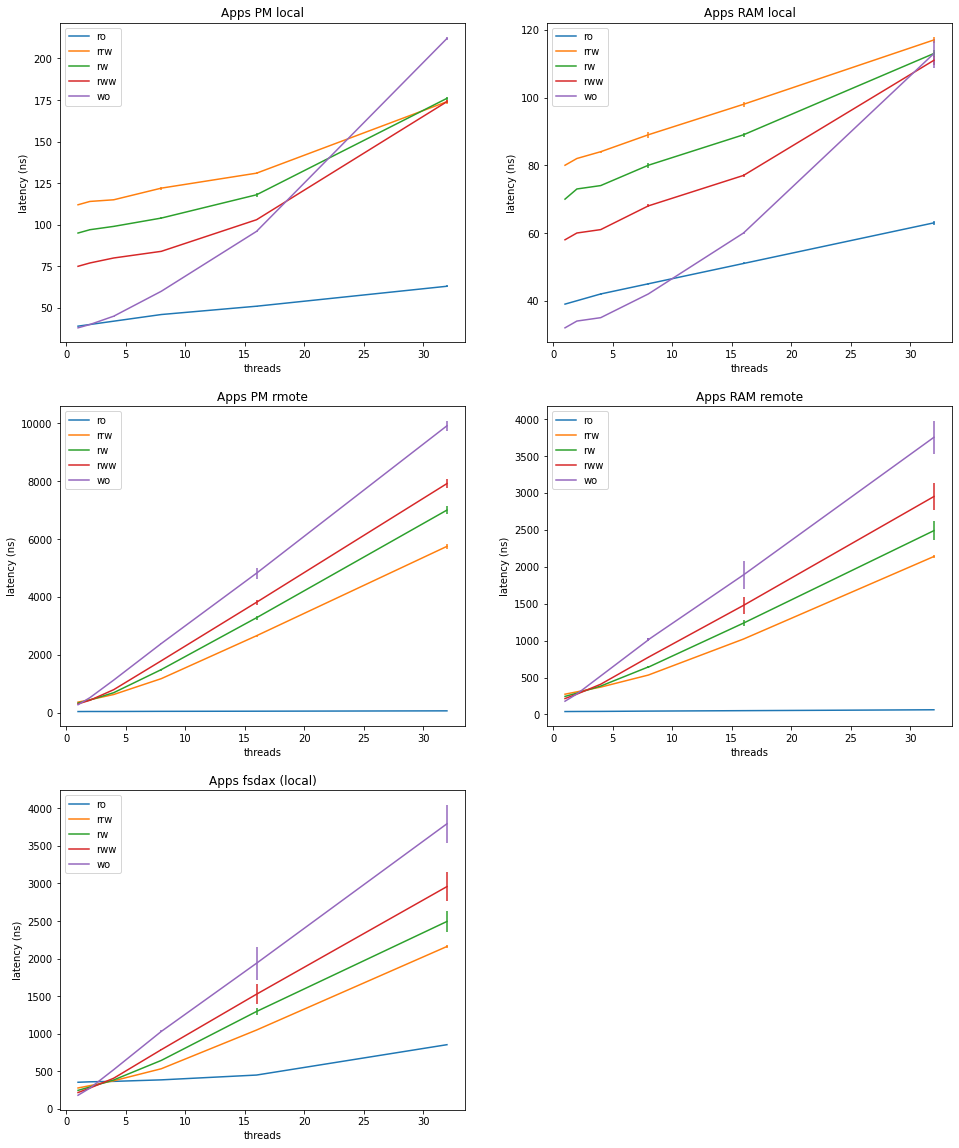

In [4]:
fig = plt.figure(figsize=(16,20))
i = 1;
for v, n in [
        (apps_pm_l, "Apps PM local"),
        (apps_ram_l, "Apps RAM local"),
        (apps_pm_r, "Apps PM rmote"),
        (apps_ram_r, "Apps RAM remote"),
        (apps_fsdax, "Apps fsdax (local)")]:
    ax = fig.add_subplot(3, 2, i)
    i+=1
    ax.set_title(n)
    plot_ratios(v, ax)